In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
mnist = fetch_openml("mnist_784")

In [3]:
data, target = mnist["data"], mnist["target"]
print(f"data의 type : {type(data)},   data의 shape : {data.shape}")
print(f"target의 type : {type(target)},   target의 shape : {target.shape}")

data의 type : <class 'pandas.core.frame.DataFrame'>,   data의 shape : (70000, 784)
target의 type : <class 'pandas.core.series.Series'>,   target의 shape : (70000,)


In [4]:
target.dtypes

CategoricalDtype(categories=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], ordered=False)

In [5]:
target = target.astype(np.int8)
data, target = data.values, target.values

print(f"data의 type : {type(data)},   data의 shape : {data.shape}")
print(f"target의 type : {type(target)},   target의 shape : {target.shape}")

data의 type : <class 'numpy.ndarray'>,   data의 shape : (70000, 784)
target의 type : <class 'numpy.ndarray'>,   target의 shape : (70000,)


In [6]:
print(target[10:20])

[3 5 3 6 1 7 2 8 6 9]


In [7]:
target_dict = {}
label, freq = np.unique(target, return_counts=True)

for l, f in zip(label, freq):
    target_dict[l] = f
    
print(target_dict)

{0: 6903, 1: 7877, 2: 6990, 3: 7141, 4: 6824, 5: 6313, 6: 6876, 7: 7293, 8: 6825, 9: 6958}


In [8]:
data = data / 255       # To keep our gradients manageable
print(np.max(data), np.min(data))

1.0 0.0


In [9]:
digits = 10
examples = target.shape[0]    # 70000

target_new = np.eye(digits)[target.reshape(1,-1)]   # target.reshape(1,-1) : (1, 70000),  target_new.shape : (1, 70000, 10)

print(target_new.shape)
print(target_new[:, 10:20])

(1, 70000, 10)
[[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]]


In [10]:
target_new = target_new.reshape(-1, 10)
print(target_new.shape)

(70000, 10)


In [11]:
m = 60000
m_test = data.shape[0] - m

x_train, x_test = data[:m].T, data[m:].T
y_train, y_test = target_new[:m].T, target_new[m:].T

print(f"x_train의 shape : {x_train.shape},   y_train의 shape : {y_train.shape}")
print(f"x_test의  shape : {x_test.shape},   y_test의 shape :  {y_test.shape}")

x_train의 shape : (784, 60000),   y_train의 shape : (10, 60000)
x_test의  shape : (784, 10000),   y_test의 shape :  (10, 10000)


In [12]:
np.random.seed(2023)

shuffle_index = np.random.permutation(m)
x_train, y_train = x_train[:, shuffle_index], y_train[:, shuffle_index]

print(f"x_train의 shape : {x_train.shape},   y_train의 shape : {y_train.shape}")
print(f"x_test의  shape : {x_test.shape},   y_test의 shape :  {y_test.shape}")

x_train의 shape : (784, 60000),   y_train의 shape : (10, 60000)
x_test의  shape : (784, 10000),   y_test의 shape :  (10, 10000)


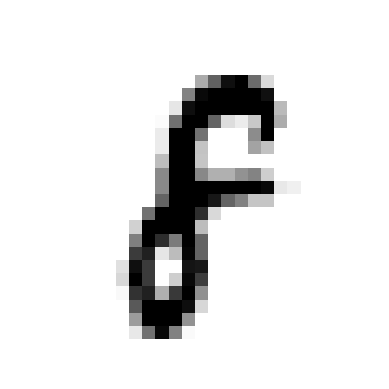

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [13]:
i = 2023 * 2
plt.imshow(x_train[:, i].reshape(28,28), cmap=matplotlib.cm.binary)
plt.axis("off")
plt.show()
print(y_train[:, i])

In [14]:
def sigmoid(z):
    s = 1.0 / (1.0 + np.exp(-z))
    return s

def compute_multiclass_loss(y, y_hat):
    L_sum = np.sum(np.multiply(y, np.log(y_hat)))
    m = y.shape[1]
    L = -(1.0/m) * L_sum
    return L

In [15]:
def feed_forward(X, params):
    cache = {}
    cache["Z1"] = np.matmul(params["W1"], X) + params["b1"]
    cache["A1"] = sigmoid(cache["Z1"])
    cache["Z2"] = np.matmul(params["W2"], cache["A1"]) + params["b2"]
    cache["A2"] = np.exp(cache["Z2"]) / np.sum(np.exp(cache["Z2"]), axis=0)
    
    return cache

In [16]:
def back_propagate(X, Y, params, cache):
    
    dz2 = cache["A2"] - Y
    dw2 = (1.0/m_batch) * np.matmul(dz2, cache["A1"].T)
    db2 = (1.0/m_batch) * np.sum(dz2, axis=1, keepdims=True)
    
    dA1 = np.matmul(params["W2"].T, dz2)
    dz1 = dA1 * sigmoid(cache["Z1"]) * (1 - sigmoid(cache["Z1"]))
    dw1 = (1.0/m_batch) * np.matmul(dz1, X.T)
    db1 = (1.0/m_batch) * np.sum(dz1, axis=1, keepdims=True)
    
    grads = {"dw1" : dw1, "db1" : db1, "dw2" : dw2, "db2" : db2}
    
    return grads

In [17]:
# Now for the substansive stuff
# To switch to mini-batch descent, we add another for loop inside the pass through each epoch. At each pass we randomly shuffle the training set, then iterate through it
# in chunks of batch_size, which we'll arbitrarily set to 128. We'll see the code for all this in a moment.
# Next, to add momentum, we keep a moving average of our gradients. So instead of upgrading our parameters by doing e.g.:
# params["W1"] = params["W1"] - learning_rate * grads["dw1"], we do this:
# v_dw1 = (beta * v_dw1 + (1 - bata) * grads["dw1"]),  params["W1"] = params["W1"] - learning_rage * v_dw1

In [17]:
np.random.seed(2023)

# hyperparameters
n_x = x_train.shape[0]
n_h = 64
learning_rate = 1
beta = 0.9
batch_size = 128
batches = -(-m // batch_size)

In [18]:
# initialization
params = {"W1" : np.random.randn(n_h, n_x) * np.sqrt(1.0/n_x),     "b1" : np.zeros((n_h, 1)) * np.sqrt(1.0/n_x),
          "W2" : np.random.randn(digits, n_h) * np.sqrt(1.0/n_h),  "b2" : np.zeros((digits, 1)) * np.sqrt(1.0/n_h)}

v_dw1 = np.zeros(params["W1"].shape)
v_db1 = np.zeros(params["b1"].shape)
v_dw2 = np.zeros(params["W2"].shape)
v_db2 = np.zeros(params["b2"].shape)

In [20]:
# train
for i in range(9):
    
    permutation = np.random.permutation(x_train.shape[1])
    x_train_shuffled = x_train[:, permutation]
    y_train_shuffled = y_train[:, permutation]
    
    for j in range(batches):
        begin = j * batch_size
        end = min(begin + batch_size, x_train.shape[1] - 1)
        X = x_train_shuffled[:, begin:end]
        Y = y_train_shuffled[:, begin:end]
        m_batch = end - begin
        
        cache = feed_forward(X, params)
        grads = back_propagate(X, Y, params, cache)
        
        v_dw1 = (beta * v_dw1 + (1.0 - beta) * grads["dw1"])
        v_db1 = (beta * v_db1 + (1.0 - beta) * grads["db1"])
        v_dw2 = (beta * v_dw2 + (1.0 - beta) * grads["dw2"])
        v_db2 = (beta * v_db2 + (1.0 - beta) * grads["db2"])
        
        params["W1"] -= learning_rate * v_dw1
        params["b1"] -= learning_rate * v_db1
        params["W2"] -= learning_rate * v_dw2
        params["b2"] -= learning_rate * v_db2
        
    cache = feed_forward(x_train, params)
    train_cost = compute_multiclass_loss(y_train, cache["A2"])
    cache = feed_forward(x_test, params)
    test_cost = compute_multiclass_loss(y_test, cache["A2"])
    print(f"Epoch {i+1:d} : training cost = {train_cost},  test cost : {test_cost}")
    
print("Done!")

Epoch 1 : training cost = 0.19376645530967887,  test cost : 0.1961419081373025
Epoch 2 : training cost = 0.15299199295317745,  test cost : 0.1588419715826621
Epoch 3 : training cost = 0.13041660850111927,  test cost : 0.14212718629785762
Epoch 4 : training cost = 0.11133348373953401,  test cost : 0.12329826532073353
Epoch 5 : training cost = 0.09673403186641309,  test cost : 0.11128546372341067
Epoch 6 : training cost = 0.08564250500939995,  test cost : 0.10460291827141845
Epoch 7 : training cost = 0.07748026503775822,  test cost : 0.09986950286901866
Epoch 8 : training cost = 0.07053965274364542,  test cost : 0.09440637475955815
Epoch 9 : training cost = 0.06633694311742425,  test cost : 0.0919795313356268
Done!


In [21]:
cache = feed_forward(x_test, params)
predictions = np.argmax(cache["A2"], axis=0)
labels = np.argmax(y_test, axis=0)

print(classification_report(predictions, labels))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       991
           1       0.99      0.99      0.99      1134
           2       0.98      0.96      0.97      1046
           3       0.97      0.98      0.97      1004
           4       0.98      0.96      0.97      1000
           5       0.97      0.96      0.96       905
           6       0.97      0.97      0.97       955
           7       0.95      0.98      0.96      1005
           8       0.97      0.96      0.96       979
           9       0.95      0.98      0.96       981

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [22]:
print(confusion_matrix(predictions, labels))

[[ 967    0    4    0    0    4    7    1    5    3]
 [   0 1120    0    0    0    1    3    6    0    4]
 [   0    4 1008    7    2    0    1   19    4    1]
 [   0    0    4  979    1    7    1    4    2    6]
 [   0    0    5    0  962    1    3    5    5   19]
 [   4    1    0   10    0  867    9    0    5    9]
 [   5    4    1    1    5    5  929    0    5    0]
 [   2    0    5    7    1    2    0  980    3    5]
 [   2    6    5    5    3    4    5    3  942    4]
 [   0    0    0    1    8    1    0   10    3  958]]
